In [1]:
import math
import matplotlib.pyplot as plt
import gprsim
import numpy as np

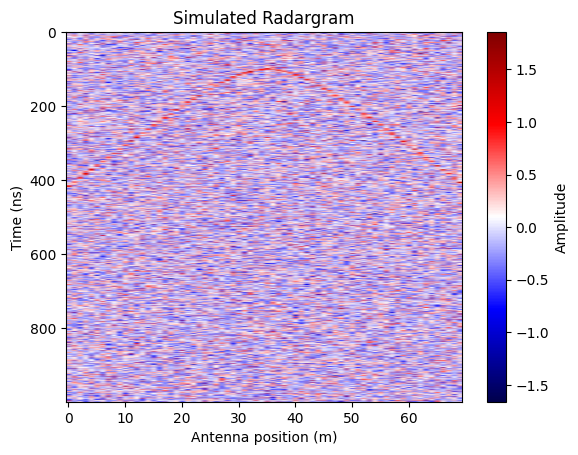

In [2]:
# Parameters
eps_r = 3                  # relative dielectric permittivity
rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 1e-6)  # grid (x,z)
SNR = 0.02
wavetype = 'gaussian'

# Point reflectors at (x,t) where x [m] and t [s]
reflectors = [(35, 50e-9)]

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)

plt.imshow(data, aspect='auto', cmap='seismic')
plt.xlabel("Antenna position (m)")
plt.ylabel("Time (ns)")
plt.title("Simulated Radargram")
plt.colorbar(label="Amplitude")
plt.show()

Text(0.5, 1.0, 'c-10%')

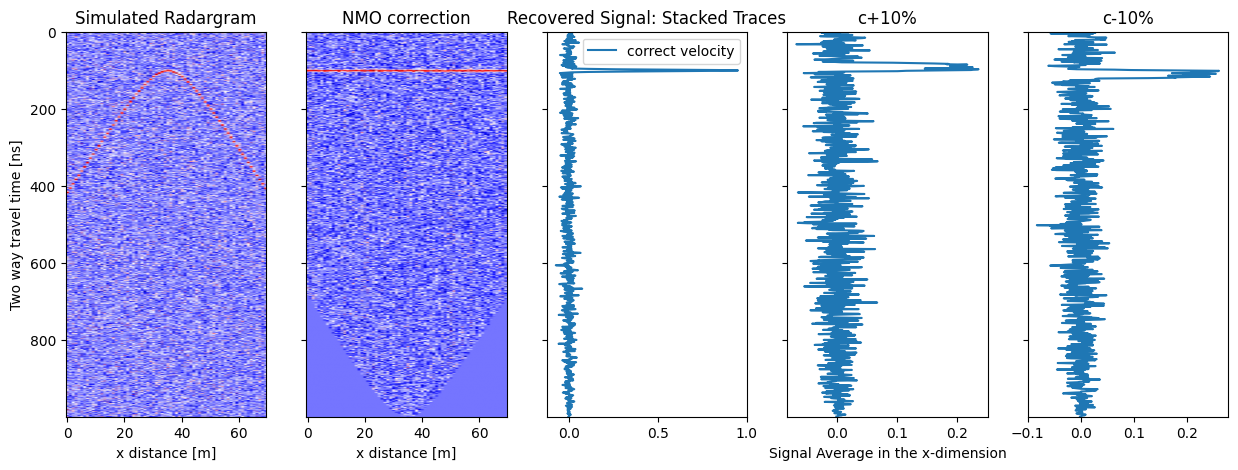

In [5]:
import numpy as np

stackh = lambda array : np.sum(array, axis=1)/array.shape[1]

t_0, x_0 = 100, 35 # The zero-offset time [ns] and 'CMP' [m] (the position of the reflector which we assume we know -- though can be estimated pretty easily)
eps_r = 3.0
wavetype = 'gaussian'
SNR = 0.06

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
corrected = gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt) 


fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
plt.gca()
axs[0].imshow(data, aspect='auto', cmap='seismic')
im = axs[1].imshow(corrected, aspect='auto', cmap='seismic')
stack = stackh(corrected)
axs[2].plot(stack, range(0,len(stack)), label='correct velocity')


eps_r = 3.3
stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
axs[3].plot(stack, range(0,len(stack)), label='velocity+10%')


eps_r = 2.7
stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
axs[4].plot(stack, range(0,len(stack)), label='velocity-10%')


'''Desktop/ResolutionGuyotProj/Code/Point_Counting/Matrix_indev/Kmask/RoPeR_prcs/GPR_modeling
Making the plot pretty
'''
axs[0].set_title('Simulated Radargram'); axs[0].set_ylabel('Two way travel time [ns]'); axs[0].set_xlabel('x distance [m]')
axs[1].set_title('NMO correction'); axs[1].set_xlabel('x distance [m]')
axs[2].set_title('Recovered Signal: Stacked Traces'); axs[2].legend()
axs[3].set_title('c+10%'); axs[3].set_xlabel('Signal Average in the x-dimension')
axs[4].set_title('c-10%')

# Now lets estimate everything!

v = 172826767.1 m/s, depth z = 8.59 m, apex x0 = 34.910 m, t0 = 4.9712905777834964e-08 s, risiduals=[ -0.79416913   0.63958563   1.87951448 -14.15840115  -1.76750783
 -16.99891059   4.90097077   5.17177008   5.24874347   5.13189095
   0.26099612  -0.07931057   3.61837794  -1.34140168   1.64023972
   4.11458699   2.47675546   4.08578504   1.89610405  -0.48740285
  -0.10171453   2.60535726   1.82718672   0.54172204  -5.99784142
   0.95688195   4.27709241   2.23871468  -2.47884422   2.95422259
 -16.57052674   0.21501984   0.66312663   2.39518631   2.18695423
   3.0238421    4.90584993   0.21271429   1.25925854   2.1940757
   3.24107166  -2.61547114   4.82822113   1.66646412   1.34107409
  -2.30536062  -0.03299074   1.73208499 -10.4071685   -1.96178234
  -2.0171302   -5.70699097  -0.3582919   -5.2269386    3.50319094
   8.94212991  -1.29211679  -4.45071187   4.62364343  -3.51267398
   1.24074956  -8.07435378  -8.44792317 -14.05320074   0.67240136
   5.45680828  -6.33505753  -7.51355881  32

Text(0.5, 1.0, 'c-10%')

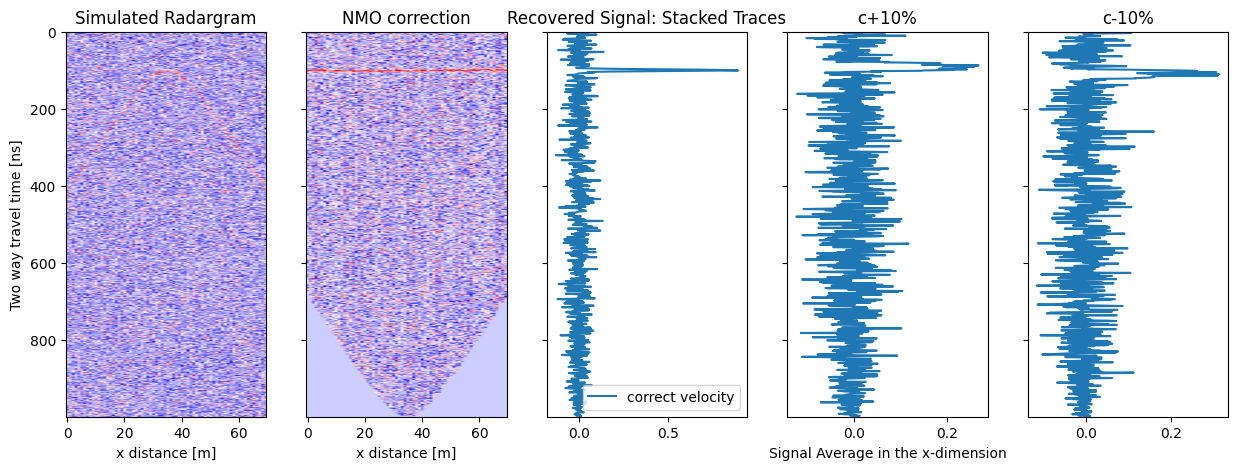

In [6]:
import numpy as np

stackh = lambda array : np.sum(array, axis=1)/array.shape[1]


t_0, x_0 = 100, 35 # The zero-offset time [ns] and 'CMP' [m] (the position of the reflector which we assume we know -- though can be estimated pretty easily)
eps_r = 3.0
wavetype = 'gaussian'
SNR = 0.015

data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)


v, z, x0, t0 = gprsim.fit_hyperbola(data, 1, 'robust_fit', dx, dt)
t_0, x_0 = (2*t0*1e9), x0 # The zero-offset time [ns] and 'CMP' [m] (the position of the reflector which we assume we know -- though can be estimated pretty easily)
eps_r = (3e8/v)**2
print(v, z, x0, t0)

corrected = gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt) 


fig, axs = plt.subplots(1, 5, figsize=(15, 5), sharey=True)
plt.gca()
axs[0].imshow(data, aspect='auto', cmap='seismic')
im = axs[1].imshow(corrected, aspect='auto', cmap='seismic')
stack = stackh(corrected)
axs[2].plot(stack, range(0,len(stack)), label='correct velocity')


eps_r = 3.3
stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
axs[3].plot(stack, range(0,len(stack)), label='velocity+10%')


eps_r = 2.7
stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
axs[4].plot(stack, range(0,len(stack)), label='velocity-10%')


'''Desktop/ResolutionGuyotProj/Code/Point_Counting/Matrix_indev/Kmask/RoPeR_prcs/GPR_modeling
Making the plot pretty
'''
axs[0].set_title('Simulated Radargram'); axs[0].set_ylabel('Two way travel time [ns]'); axs[0].set_xlabel('x distance [m]')
axs[1].set_title('NMO correction'); axs[1].set_xlabel('x distance [m]')
axs[2].set_title('Recovered Signal: Stacked Traces'); axs[2].legend()
axs[3].set_title('c+10%'); axs[3].set_xlabel('Signal Average in the x-dimension')
axs[4].set_title('c-10%')

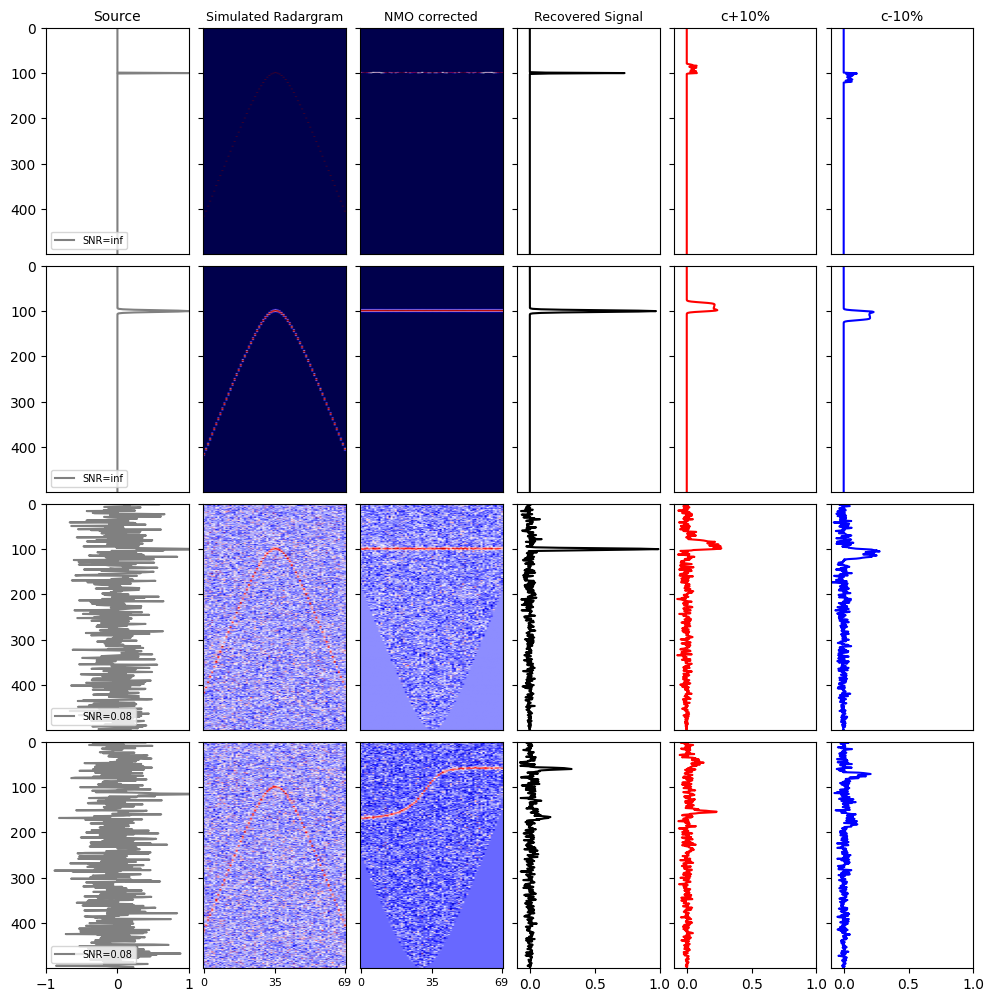

In [71]:
correct_t_0 = 100; correct_x_0 = 35; correct_eps_r = 3.0
params = {0:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'spike', 'SNR':math.inf}, 
          1:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':math.inf}, 
          2:{'t_0':correct_t_0, 'x_0':correct_x_0, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':0.08}, 
          3:{'t_0':correct_t_0+20, 'x_0':correct_x_0-5, 'eps_r':correct_eps_r, 'wavetype':'gaussian', 'SNR':0.08}}

rf = 400e6                 # radar frequency different from pulse frequency
dt = 1e-9                  # seconds
dx = 1                     # meters
region_shape = (70, 5e-7)  # grid (x,z)
reflectors = [(35, 50e-9)]

fig, axs = plt.subplots(4, 6, figsize=(10,10), sharey=True)
fig.tight_layout()
if isinstance(axs, np.ndarray):
    grid = axs.shape
    
for i in range(grid[0]):
    # Simulate a survey
    t_0, x_0 = params[i]['t_0'], params[i]['x_0']
    eps_r = params[i]['eps_r']
    wavetype = params[i]['wavetype']
    SNR = params[i]['SNR']

    data, x_positions, t_samples = gprsim.gprsim(eps_r, rf, dt, dx, reflectors, region_shape, wavetype, SNR)
    corrected = gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt) 
    stack = stackh(corrected)

    axs[i][0].plot(data[:, x_0], range(0,len(stack)), c='gray', label=f'SNR={SNR}')
    axs[i][0].set_xlim(-1, 1)
    axs[i][0].legend(fontsize=7, loc='lower left')
    
    axs[i][1].imshow(data, aspect='auto', cmap='seismic')
    axs[i][1].set_xticks([0, 35, 69])
    for label in axs[i][1].get_xticklabels():
        label.set_fontsize(8)
    
    im = axs[i][2].imshow(corrected, aspect='auto', cmap='seismic')
    axs[i][2].set_xticks([0, 35, 69])
    for label in axs[i][2].get_xticklabels():
        label.set_fontsize(8)

    axs[i][3].plot(stack, range(0,len(stack)), label='correct velocity', c='black')
    axs[i][3].set_xlim(-0.1, 1)



    eps_r = 3.3
    stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
    axs[i][4].plot(stack, range(0,len(stack)), label='velocity+10%', c='red')
    axs[i][4].set_xlim(-0.1, 1)


    eps_r = 2.7
    stack = stackh(gprsim.NMO_correction(data, eps_r, t_0, x_0, region_shape, dx, dt))
    axs[i][5].plot(stack, range(0,len(stack)), label='velocity-10%', c='blue')
    axs[i][5].set_xlim(-0.1, 1)

    if i != 3:
        for j in range(0, 6):
            axs[i][j].set_xticks([])
        

    
    # Making the plot pretty
    # '''
axs[0, 0].set_title('Source', fontsize=10, pad=5); axs[0, 1].set_title('Simulated Radargram', fontsize=9, pad=5); axs[0, 2].set_title('NMO corrected', fontsize=9, pad=5); axs[0, 3].set_title('Recovered Signal', fontsize=9, pad=5); axs[0, 4].set_title('c+10%', fontsize=10, pad=5);  axs[0, 5].set_title('c-10%', fontsize=10, pad=5);
plt.subplots_adjust(hspace=0.05, wspace=0.1)

plt.savefig('/Users/coltenrodriguez/desktop/Senior_Thesis/Thesis/Figures/NMO_Figure_Draft.png')
    # axs[1].set_title('NMO correction'); axs[1].set_xlabel('x distance [m]'), ; fig.colorbar(im, ax=axs[1], orientation='vertical')
    # axs[2].set_title('Recovered Signal: Stacked Traces'); axs[2].legend()
    # axs[3].set_title('c+10%'); axs[3].set_xlabel('Signal Average in the x-dimension')
    # axs[4].set_title('c-10%')